# 🤖 Multi-Agent AI Interviewer System

An advanced, production-ready AI-powered interview platform using LangGraph and Claude Sonnet 4.

## 🌟 Features

### Core Capabilities
- **4 Specialized AI Agents**: HR, Technical, Behavioral, and Evaluator agents with distinct roles
- **Dynamic Difficulty Adjustment**: Automatically adjusts question difficulty based on performance
- **Real-time Stress Detection**: Analyzes linguistic markers to detect candidate stress
- **Confidence Analysis**: Evaluates confidence levels from response patterns
- **STAR Method**: Behavioral questions follow the Situation-Task-Action-Result framework
- **Bias Detection**: Automatically flags potentially biased questions
- **Communication Scoring**: Evaluates response quality and clarity

### Advanced Analytics
- **Multi-dimensional Evaluation**: Technical, behavioral, cultural fit, communication
- **Performance Tracking**: Success rates, stress levels, confidence over time
- **Comprehensive Reporting**: JSON export with full interview history
- **Visual Analytics**: Radar charts, performance graphs, trajectory analysis

### Technical Features
- **LangGraph Workflow**: State-based multi-agent orchestration
- **Anthropic Claude Sonnet 4**: Latest AI model for intelligent responses
- **Sentiment Analysis**: VADER + TextBlob for emotional intelligence
- **Structured Outputs**: Pydantic models for data validation

# Installation and Setup

In [62]:
"""
Multi-Agent AI Interviewer System
==================================
A sophisticated AI-powered interview platform with multiple specialized agents

"""

!pip install -q langgraph langchain langchain-anthropic langchain-community
!pip install -q python-dotenv pydantic typing-extensions
!pip install -q textblob vaderSentiment

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


# Importing the libraries

In [63]:
import os
import json
from typing import TypedDict, Annotated, List, Dict, Optional
from datetime import datetime
import operator
from getpass import getpass
import time

# LangGraph and LangChain imports
from langgraph.graph import StateGraph, END
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate

# Sentiment and text analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Pydantic for data validation
from pydantic import BaseModel, Field

# Setting up the API Key

In [64]:
# Set up API Key with validation
def setup_api_key():
    """Setup and validate API key"""
    if "ANTHROPIC_API_KEY" in os.environ:
        print("✅ Using existing API key from environment")
        return True

    api_key = getpass("Enter your Anthropic API Key: ")

    if not api_key or len(api_key) < 10:
        print("❌ Invalid API key")
        return False

    os.environ["ANTHROPIC_API_KEY"] = api_key
    print("✅ API key set")
    return True

# Setup API
if not setup_api_key():
    raise Exception("API key setup failed")

✅ Using existing API key from environment


# Configuring the LLM

In [65]:
# Clean your existing API key
import os
if "ANTHROPIC_API_KEY" in os.environ:
    os.environ["ANTHROPIC_API_KEY"] = os.environ["ANTHROPIC_API_KEY"].strip()
    print("✅ API key cleaned")

# OR set it fresh (paste your key, it will auto-strip)
from getpass import getpass
clean_key = getpass("Enter API key again: ").strip()
os.environ["ANTHROPIC_API_KEY"] = clean_key

# Test it
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage

llm = ChatAnthropic(
    model="claude-sonnet-4-20250514",
    temperature=0.7,
    max_tokens=100
)

response = llm.invoke([HumanMessage(content="Say hi")])
print("✅ Success:", response.content)

✅ API key cleaned
Enter API key again: ··········
✅ Success: Hi there! How are you doing today?


In [66]:
def safe_llm_call(prompt: str, max_retries: int = 3, max_tokens: int = 2000) -> Optional[str]:
    """Make LLM call with retry logic and error handling"""
    for attempt in range(max_retries):
        try:
            # Create a fresh LLM instance with the specified max_tokens
            temp_llm = ChatAnthropic(
                model="claude-sonnet-4-20250514",
                temperature=0.7,
                max_tokens=max_tokens,  # This is critical!
                timeout=60.0,
                max_retries=2
            )
            response = temp_llm.invoke([HumanMessage(content=prompt)])
            return response.content
        except Exception as e:
            print(f"⚠️ API call failed (attempt {attempt + 1}/{max_retries}): {str(e)}")
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt
                print(f"   Retrying in {wait_time} seconds...")
                import time
                time.sleep(wait_time)

    print("❌ All retry attempts exhausted")
    return None
def extract_json_safely(text: str) -> Optional[dict]:
    """Extract JSON from LLM response with error handling"""
    if not text:
        return None

    try:
        # Remove markdown code blocks
        if "```json" in text:
            text = text.split("```json")[1].split("```")[0].strip()
        elif "```" in text:
            text = text.split("```")[1].split("```")[0].strip()

        # Try direct parse
        return json.loads(text)

    except json.JSONDecodeError as e:
        print(f"⚠️ JSON parse error at position {e.pos}: {e.msg}")
        print(f"Response length: {len(text)} characters")
        print(f"Response preview: {text[:500]}...")

        # Try to extract just the JSON object using regex
        import re
        # Look for outermost braces
        json_match = re.search(r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}', text, re.DOTALL)
        if json_match:
            try:
                extracted = json_match.group()
                print(f"   Found potential JSON, attempting parse...")
                return json.loads(extracted)
            except:
                print(f"   Regex extraction also failed")

        return None

#State & Data Models - Pydantic models, TypedDict states


In [67]:
# Define Interview State
class InterviewState(TypedDict):
    """Shared state across all interview agents"""
    candidate_name: str
    position: str
    experience_level: str  # junior, mid, senior

    # Conversation history
    messages: Annotated[List[Dict], operator.add]

    # Agent-specific data
    hr_questions: List[str]
    technical_questions: List[str]
    behavioral_questions: List[str]

    hr_responses: List[Dict]
    technical_responses: List[Dict]
    behavioral_responses: List[Dict]

    # Analysis metrics
    stress_level: float  # 0-1 scale
    confidence_score: float  # 0-1 scale
    technical_competency: float  # 0-10 scale
    communication_score: float  # 0-10 scale
    cultural_fit_score: float  # 0-10 scale

    # Dynamic difficulty
    current_difficulty: str  # easy, medium, hard
    questions_asked: int
    correct_answers: int

    # Bias detection
    bias_flags: List[str]

    # Final evaluation
    overall_score: float
    recommendation: str
    detailed_feedback: str

    # Control flow
    current_agent: str
    interview_complete: bool
    has_errors: bool

# Pydantic models for structured outputs
class QuestionGeneration(BaseModel):
    """Model for generating interview questions"""
    questions: List[str] = Field(description="List of interview questions")
    difficulty: str = Field(description="Difficulty level: easy, medium, or hard")
    follow_up_topics: List[str] = Field(description="Potential follow-up topics")

class ResponseEvaluation(BaseModel):
    """Model for evaluating candidate responses"""
    score: float = Field(description="Score from 0-10")
    strengths: List[str] = Field(description="Identified strengths")
    weaknesses: List[str] = Field(description="Areas for improvement")
    confidence_level: str = Field(description="Confidence level: low, medium, high")
    needs_follow_up: bool = Field(description="Whether follow-up is needed")

class FinalEvaluation(BaseModel):
    """Model for final candidate evaluation"""
    overall_score: float = Field(description="Overall score from 0-10")
    recommendation: str = Field(description="hire, maybe, or no_hire")
    technical_rating: float
    behavioral_rating: float
    cultural_fit_rating: float
    key_strengths: List[str]
    key_concerns: List[str]
    detailed_feedback: str

print("✅ State and data models defined!")
print("📊 Interview tracking: Stress, Confidence, Technical, Communication, Cultural Fit")
print("🎯 Dynamic difficulty adjustment enabled")
print("⚖️ Bias detection integrated")

✅ State and data models defined!
📊 Interview tracking: Stress, Confidence, Technical, Communication, Cultural Fit
🎯 Dynamic difficulty adjustment enabled
⚖️ Bias detection integrated


#Analysis Utilities - Stress detection, bias detection, sentiment analysis


In [68]:
class ResponseAnalyzer:
    """Advanced analysis utilities for candidate responses"""

    @staticmethod
    def detect_stress_level(text: str) -> float:
        """
        Detect stress level from linguistic markers
        Returns: 0-1 scale (0=calm, 1=highly stressed)
        """
        stress_indicators = {
            'high': ['um', 'uh', 'err', 'well...', 'i guess', 'maybe',
                    'not sure', 'difficult', 'hard', 'struggle', 'confused'],
            'medium': ['think', 'believe', 'suppose', 'probably', 'might'],
            'low': ['confident', 'certain', 'definitely', 'absolutely', 'sure']
        }

        text_lower = text.lower()

        high_count = sum(text_lower.count(word) for word in stress_indicators['high'])
        medium_count = sum(text_lower.count(word) for word in stress_indicators['medium'])
        low_count = sum(text_lower.count(word) for word in stress_indicators['low'])

        # Calculate stress score
        stress_score = (high_count * 0.8 + medium_count * 0.4 - low_count * 0.3)
        stress_score = max(0, min(1, stress_score / 5))  # Normalize to 0-1

        # Sentiment analysis
        sentiment = sentiment_analyzer.polarity_scores(text)
        if sentiment['compound'] < -0.3:
            stress_score += 0.2

        return min(1.0, stress_score)

    @staticmethod
    def detect_confidence(text: str) -> float:
        """
        Detect confidence level from response
        Returns: 0-1 scale (0=low confidence, 1=high confidence)
        """
        confidence_markers = {
            'high': ['definitely', 'certainly', 'confident', 'absolutely',
                    'without doubt', 'clearly', 'obviously', 'exactly'],
            'low': ['maybe', 'perhaps', 'might', 'could be', 'not sure',
                   'i think', 'i guess', 'possibly', 'probably']
        }

        text_lower = text.lower()

        high_count = sum(text_lower.count(word) for word in confidence_markers['high'])
        low_count = sum(text_lower.count(word) for word in confidence_markers['low'])

        # Response length and completeness
        word_count = len(text.split())
        length_factor = min(1.0, word_count / 50)  # Longer answers show more confidence

        confidence = (high_count * 0.2 - low_count * 0.15 + length_factor * 0.5)
        return max(0, min(1, confidence))

    @staticmethod
    def detect_bias(question: str, context: str) -> List[str]:
        """
        Detect potential bias in questions
        Returns: List of bias types detected
        """
        bias_patterns = {
            'age': ['young', 'old', 'millennial', 'generation', 'age'],
            'gender': ['he', 'she', 'masculine', 'feminine', 'guys', 'girls'],
            'cultural': ['native', 'foreign', 'accent', 'background', 'where are you from'],
            'personal': ['married', 'children', 'family', 'pregnant', 'religion'],
            'disability': ['health', 'disability', 'medical', 'condition']
        }

        detected_bias = []
        text_lower = (question + " " + context).lower()

        for bias_type, keywords in bias_patterns.items():
            if any(keyword in text_lower for keyword in keywords):
                detected_bias.append(bias_type)

        return detected_bias

    @staticmethod
    def analyze_communication_quality(text: str) -> float:
        """
        Analyze communication quality
        Returns: 0-10 scale
        """
        blob = TextBlob(text)

        # Factors: grammar, length, sentiment, clarity
        word_count = len(text.split())
        sentence_count = len(blob.sentences)

        # Optimal length (50-200 words)
        length_score = min(10, (word_count / 20)) if word_count < 200 else 10 - (word_count - 200) / 50
        length_score = max(0, min(10, length_score))

        # Sentence structure (2-4 sentences is good)
        structure_score = 10 if 2 <= sentence_count <= 4 else max(0, 10 - abs(sentence_count - 3) * 2)

        # Sentiment (positive is good)
        sentiment = sentiment_analyzer.polarity_scores(text)
        sentiment_score = (sentiment['compound'] + 1) * 5  # Convert -1,1 to 0,10

        # Average the scores
        communication_score = (length_score * 0.4 + structure_score * 0.3 + sentiment_score * 0.3)
        return round(communication_score, 2)

# Initialize analyzer
analyzer = ResponseAnalyzer()

print("✅ Analysis utilities ready!")
print("🧠 Capabilities:")
print("   - Stress detection from linguistic markers")
print("   - Confidence level analysis")
print("   - Bias detection in questions")
print("   - Communication quality assessment")

✅ Analysis utilities ready!
🧠 Capabilities:
   - Stress detection from linguistic markers
   - Confidence level analysis
   - Bias detection in questions
   - Communication quality assessment


## 📊 System Architecture

```
┌─────────────┐
│   START     │
└──────┬──────┘
       │
       ▼
┌─────────────┐
│  HR Agent   │  → Cultural fit, Communication
└──────┬──────┘
       │
       ▼
┌─────────────┐
│ Technical   │  → Skills assessment, Problem-solving
│   Agent     │  → Dynamic difficulty adjustment
└──────┬──────┘
       │
       ▼
┌─────────────┐
│ Behavioral  │  → STAR method, Soft skills
│   Agent     │  → Past experiences
└──────┬──────┘
       │
       ▼
┌─────────────┐
│ Evaluator   │  → Final assessment
│   Agent     │  → Hiring recommendation
└──────┬──────┘
       │
       ▼
┌─────────────┐
│     END     │
└─────────────┘
```

# HR Agent - Cultural fit & communication assessment

In [69]:
def hr_agent(state: InterviewState) -> InterviewState:
    """
    HR Agent: Handles initial screening, cultural fit, and behavioral assessment
    Focus: Communication, motivation, cultural alignment, work ethic
    """
    print("\n" + "="*60)
    print("👔 HR AGENT ACTIVE")
    print("="*60)

    # Generate HR questions based on experience level and difficulty
    hr_prompt = f"""You are an experienced HR interviewer conducting an interview for a {state['position']} position.

Candidate Profile:
- Name: {state['candidate_name']}
- Experience Level: {state['experience_level']}
- Position: {state['position']}

Current Difficulty: {state.get('current_difficulty', 'medium')}
Questions Asked So Far: {state.get('questions_asked', 0)}

Generate {3 if state.get('questions_asked', 0) == 0 else 2} relevant HR interview questions that assess:
1. Cultural fit and values alignment
2. Communication skills
3. Work ethic and motivation
4. Team collaboration abilities
5. Career goals and aspirations

Make questions natural, conversational, and appropriate for {state['experience_level']} level.
Difficulty level should be {state.get('current_difficulty', 'medium')}.

Return ONLY a JSON object with this structure:
{{
    "questions": ["question1", "question2", ...],
    "difficulty": "easy|medium|hard",
    "follow_up_topics": ["topic1", "topic2"]
}}"""

    try:
      response_text = safe_llm_call(hr_prompt, max_tokens=1500)

      if not response_text:
          raise Exception("No response from API")

      questions_data = extract_json_safely(response_text)

      if not questions_data or 'questions' not in questions_data:
          raise Exception("Invalid JSON response")

      questions = questions_data['questions']

      if not questions or len(questions) == 0:
          raise Exception("No questions generated")
      # Store questions
      state['hr_questions'] = questions

      # Display questions
      print("\n💬 HR Questions:")
      for i, q in enumerate(questions, 1):
          print(f"\n{i}. {q}")

      # Get candidate responses
      print("\n" + "-"*60)
      print("📝 CANDIDATE RESPONSES:")
      print("-"*60)

      hr_responses = []
      for i, question in enumerate(questions, 1):
          print(f"\nQuestion {i}: {question}")
          answer = input("Your answer: ").strip()

          # Analyze response
          stress = analyzer.detect_stress_level(answer)
          confidence = analyzer.detect_confidence(answer)
          communication = analyzer.analyze_communication_quality(answer)
          bias = analyzer.detect_bias(question, answer)

          response_data = {
              'question': question,
              'answer': answer,
              'stress_level': stress,
              'confidence': confidence,
              'communication_score': communication,
              'timestamp': datetime.now().isoformat()
          }
          hr_responses.append(response_data)

          # Update state metrics
          state['stress_level'] = (state.get('stress_level', 0) * state.get('questions_asked', 0) + stress) / (state.get('questions_asked', 0) + 1)
          state['confidence_score'] = (state.get('confidence_score', 0) * state.get('questions_asked', 0) + confidence) / (state.get('questions_asked', 0) + 1)
          state['communication_score'] = (state.get('communication_score', 0) * state.get('questions_asked', 0) + communication) / (state.get('questions_asked', 0) + 1)
          state['questions_asked'] = state.get('questions_asked', 0) + 1

          if bias:
              state['bias_flags'].extend([f"HR-Q{i}: {b}" for b in bias])

          # Display quick analysis
          print(f"   📊 Stress: {stress:.2f} | Confidence: {confidence:.2f} | Communication: {communication:.2f}")

      state['hr_responses'] = hr_responses

      # Evaluate cultural fit
      evaluation_prompt = f"""Evaluate the candidate's cultural fit based on their HR interview responses.

Responses:
{json.dumps(hr_responses, indent=2)}

Provide a cultural fit score (0-10) and brief analysis."""

      eval_response = llm.invoke([HumanMessage(content=evaluation_prompt)])

      # Extract score
      score_text = eval_response.content
      try:
          import re
          score_match = re.search(r'(\d+(?:\.\d+)?)\s*(?:/\s*10)?', score_text)
          if score_match:
              cultural_fit = float(score_match.group(1))
              state['cultural_fit_score'] = min(10, cultural_fit)
      except:
          state['cultural_fit_score'] = 7.0  # Default

      print(f"\n✅ HR Assessment Complete!")
      print(f"   Cultural Fit Score: {state.get('cultural_fit_score', 0):.1f}/10")

      state['messages'].append({
          'agent': 'HR',
          'questions': questions,
          'responses': hr_responses,
          'cultural_fit_score': state.get('cultural_fit_score', 0)
      })

    except Exception as e:
      print(f"❌ Error in HR Agent: {e}")
      print(f"   Error type: {type(e).__name__}")
      import traceback
      print(f"   Stack trace: {traceback.format_exc()}")

      # Use fallback questions
      print("\n⚠️ Using fallback questions due to API error")
      state['hr_questions'] = [
          "Tell me about yourself and your background.",
          "Why are you interested in this position?",
          "What are your key strengths?"
      ]
      state['hr_responses'] = []
      state['has_errors'] = True  # Mark that errors occurred

    state['current_agent'] = 'technical'
    return state

print("✅ HR Agent loaded!")
print("Focus areas: Cultural fit, Communication, Motivation, Team collaboration")

✅ HR Agent loaded!
Focus areas: Cultural fit, Communication, Motivation, Team collaboration


# Technical Agent - Skills evaluation with dynamic difficulty


In [70]:
def technical_agent(state: InterviewState) -> InterviewState:
    """
    Technical Agent: Assesses technical skills, problem-solving, and domain knowledge
    Focus: Technical competency, problem-solving, coding ability, system design
    """
    print("\n" + "="*60)
    print("💻 TECHNICAL AGENT ACTIVE")
    print("="*60)

    # Adjust difficulty based on performance
    performance_ratio = state.get('correct_answers', 0) / max(1, state.get('questions_asked', 1))

    if performance_ratio > 0.8 and state.get('current_difficulty') != 'hard':
        state['current_difficulty'] = 'hard'
        print("⬆️ Increasing difficulty to HARD based on strong performance")
    elif performance_ratio < 0.4 and state.get('current_difficulty') == 'hard':
        state['current_difficulty'] = 'medium'
        print("⬇️ Adjusting difficulty to MEDIUM")

    # Generate technical questions
    tech_prompt = f"""You are a senior technical interviewer for a {state['position']} position.

Candidate Profile:
- Experience Level: {state['experience_level']}
- Position: {state['position']}
- Current Performance: {performance_ratio:.1%} success rate
- Current Difficulty: {state.get('current_difficulty', 'medium')}

Generate 3 technical interview questions that assess:
1. Core technical knowledge for {state['position']}
2. Problem-solving abilities
3. System design thinking (if appropriate)
4. Best practices and code quality awareness

Difficulty: {state.get('current_difficulty', 'medium')}
Experience: {state['experience_level']}

For a GenAI Engineer position, focus on:
- LLM fundamentals (transformers, attention, fine-tuning)
- Prompt engineering and RAG
- Vector databases and embeddings
- LangChain/LangGraph frameworks
- Evaluation metrics for LLMs
- Production deployment considerations

Return ONLY a JSON object:
{{
    "questions": ["question1", "question2", "question3"],
    "difficulty": "easy|medium|hard",
    "follow_up_topics": ["topic1", "topic2"]
}}"""

    try:
        response_text = safe_llm_call(tech_prompt, max_tokens=1500)
        if not response_text:
            raise Exception("No response from API")

        # Extract JSON
        if "```json" in response_text:
            response_text = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            response_text = response_text.split("```")[1].split("```")[0].strip()

        questions_data = json.loads(response_text)
        questions = questions_data['questions']

        state['technical_questions'] = questions

        print("\n💻 Technical Questions:")
        for i, q in enumerate(questions, 1):
            print(f"\n{i}. {q}")

        # Get and evaluate responses
        print("\n" + "-"*60)
        print("📝 CANDIDATE RESPONSES:")
        print("-"*60)

        technical_responses = []
        for i, question in enumerate(questions, 1):
            print(f"\nQuestion {i}: {question}")
            answer = input("Your answer: ").strip()

            # Evaluate technical accuracy
            eval_prompt = f"""Evaluate this technical answer on a scale of 0-10.

Question: {question}
Answer: {answer}
Position: {state['position']}
Experience Level: {state['experience_level']}

Consider:
- Technical accuracy
- Depth of knowledge
- Practical understanding
- Best practices awareness

Return ONLY a JSON object:
{{
    "score": 7.5,
    "strengths": ["point1", "point2"],
    "weaknesses": ["point1"],
    "confidence_level": "high|medium|low",
    "needs_follow_up": true
}}"""

            eval_text = safe_llm_call(eval_prompt, max_tokens=1000)
            if not eval_text:
                eval_text = '{"score": 5.0, "strengths": [], "weaknesses": [], "confidence_level": "medium", "needs_follow_up": false}'

            # Extract JSON
            if "```json" in eval_text:
                eval_text = eval_text.split("```json")[1].split("```")[0].strip()
            elif "```" in eval_text:
                eval_text = eval_text.split("```")[1].split("```")[0].strip()

            try:
                evaluation = json.loads(eval_text)
                tech_score = evaluation['score']
            except:
                tech_score = 5.0

            # Analyze response quality
            stress = analyzer.detect_stress_level(answer)
            confidence = analyzer.detect_confidence(answer)
            communication = analyzer.analyze_communication_quality(answer)

            response_data = {
                'question': question,
                'answer': answer,
                'technical_score': tech_score,
                'stress_level': stress,
                'confidence': confidence,
                'communication_score': communication,
                'evaluation': evaluation if 'evaluation' in locals() else {},
                'timestamp': datetime.now().isoformat()
            }
            technical_responses.append(response_data)

            # Update metrics
            state['stress_level'] = (state.get('stress_level', 0) * state.get('questions_asked', 0) + stress) / (state.get('questions_asked', 0) + 1)
            state['confidence_score'] = (state.get('confidence_score', 0) * state.get('questions_asked', 0) + confidence) / (state.get('questions_asked', 0) + 1)
            state['questions_asked'] = state.get('questions_asked', 0) + 1

            if tech_score >= 7:
                state['correct_answers'] = state.get('correct_answers', 0) + 1

            print(f"   📊 Technical Score: {tech_score:.1f}/10 | Stress: {stress:.2f} | Confidence: {confidence:.2f}")

        state['technical_responses'] = technical_responses

        # Calculate technical competency
        avg_tech_score = sum(r['technical_score'] for r in technical_responses) / len(technical_responses)
        state['technical_competency'] = avg_tech_score

        print(f"\n✅ Technical Assessment Complete!")
        print(f"   Technical Competency: {avg_tech_score:.1f}/10")
        print(f"   Overall Success Rate: {state.get('correct_answers', 0)}/{state.get('questions_asked', 0)}")

        state['messages'].append({
            'agent': 'Technical',
            'questions': questions,
            'responses': technical_responses,
            'technical_competency': avg_tech_score
        })

    except Exception as e:
        print(f"⚠️ Error in Technical Agent: {e}")
        state['technical_questions'] = ["Describe your technical experience."]
        state['technical_responses'] = []
        state['technical_competency'] = 5.0

    state['current_agent'] = 'behavioral'
    return state

print("✅ Technical Agent loaded!")
print("Focus areas: Technical skills, Problem-solving, Code quality, System design")

✅ Technical Agent loaded!
Focus areas: Technical skills, Problem-solving, Code quality, System design


#Behavioral Agent - STAR method implementation

In [71]:
def behavioral_agent(state: InterviewState) -> InterviewState:
    """
    Behavioral Agent: Assesses past behavior, soft skills, and situational responses
    Focus: Leadership, conflict resolution, adaptability, past experiences
    """
    print("\n" + "="*60)
    print("🎭 BEHAVIORAL AGENT ACTIVE")
    print("="*60)

    # Generate behavioral questions using STAR method
    behavioral_prompt = f"""You are an expert behavioral interviewer using the STAR method (Situation, Task, Action, Result).

Candidate Profile:
- Experience Level: {state['experience_level']}
- Position: {state['position']}
- Technical Score: {state.get('technical_competency', 5):.1f}/10
- Cultural Fit: {state.get('cultural_fit_score', 5):.1f}/10

Generate 3 behavioral interview questions that assess:
1. Problem-solving and decision-making
2. Teamwork and collaboration
3. Handling pressure and challenges
4. Leadership and initiative
5. Learning and adaptability

Use STAR method framework. Questions should be appropriate for {state['experience_level']} level.

Return ONLY a JSON object:
{{
    "questions": ["Tell me about a time when...", "Describe a situation where...", "Give me an example of..."],
    "difficulty": "medium",
    "follow_up_topics": ["topic1", "topic2"]
}}"""

    try:
        # Generate questions using safe_llm_call
        response_text = safe_llm_call(behavioral_prompt, max_tokens=1500)

        if not response_text:
            raise Exception("No response from API")

        questions_data = extract_json_safely(response_text)

        if not questions_data or 'questions' not in questions_data:
            raise Exception("Invalid JSON response")

        questions = questions_data['questions']

        state['behavioral_questions'] = questions

        print("\n🎭 Behavioral Questions (STAR Method):")
        print("   Remember: Situation, Task, Action, Result")
        for i, q in enumerate(questions, 1):
            print(f"\n{i}. {q}")

        # Get responses
        print("\n" + "-"*60)
        print("📝 CANDIDATE RESPONSES:")
        print("-"*60)

        behavioral_responses = []
        for i, question in enumerate(questions, 1):
            print(f"\nQuestion {i}: {question}")
            print("(Tip: Structure your answer using STAR - Situation, Task, Action, Result)")
            answer = input("Your answer: ").strip()

            # Evaluate STAR completeness and quality
            eval_prompt = f"""Evaluate this behavioral answer using the STAR method framework.

Question: {question}
Answer: {answer}

Assess:
1. STAR Completeness (Situation, Task, Action, Result all present?)
2. Specific and detailed vs vague
3. Demonstrates relevant skills
4. Shows self-awareness and learning

Return ONLY a JSON object:
{{
    "score": 8.0,
    "strengths": ["point1", "point2"],
    "weaknesses": ["point1"],
    "confidence_level": "high",
    "needs_follow_up": false,
    "star_complete": true
}}"""

            # Evaluate using safe_llm_call
            eval_text = safe_llm_call(eval_prompt, max_tokens=1000)

            if eval_text:
                evaluation = extract_json_safely(eval_text)
                if evaluation and 'score' in evaluation:
                    behavioral_score = evaluation['score']
                else:
                    behavioral_score = 6.0
                    evaluation = {'score': 6.0, 'strengths': [], 'weaknesses': [],
                                 'confidence_level': 'medium', 'needs_follow_up': False,
                                 'star_complete': False}
            else:
                behavioral_score = 6.0
                evaluation = {'score': 6.0, 'strengths': [], 'weaknesses': [],
                             'confidence_level': 'medium', 'needs_follow_up': False,
                             'star_complete': False}

            # Analyze response
            stress = analyzer.detect_stress_level(answer)
            confidence = analyzer.detect_confidence(answer)
            communication = analyzer.analyze_communication_quality(answer)

            response_data = {
                'question': question,
                'answer': answer,
                'behavioral_score': behavioral_score,
                'stress_level': stress,
                'confidence': confidence,
                'communication_score': communication,
                'evaluation': evaluation,
                'timestamp': datetime.now().isoformat()
            }
            behavioral_responses.append(response_data)

            # Update metrics
            state['stress_level'] = (state.get('stress_level', 0) * state.get('questions_asked', 0) + stress) / (state.get('questions_asked', 0) + 1)
            state['confidence_score'] = (state.get('confidence_score', 0) * state.get('questions_asked', 0) + confidence) / (state.get('questions_asked', 0) + 1)
            state['questions_asked'] = state.get('questions_asked', 0) + 1

            print(f"   📊 Behavioral Score: {behavioral_score:.1f}/10 | STAR: {'✅' if evaluation.get('star_complete', False) else '⚠️'}")

        state['behavioral_responses'] = behavioral_responses

        # Calculate behavioral score
        avg_behavioral_score = sum(r['behavioral_score'] for r in behavioral_responses) / len(behavioral_responses)

        print(f"\n✅ Behavioral Assessment Complete!")
        print(f"   Behavioral Score: {avg_behavioral_score:.1f}/10")

        state['messages'].append({
            'agent': 'Behavioral',
            'questions': questions,
            'responses': behavioral_responses,
            'behavioral_score': avg_behavioral_score
        })

    except Exception as e:
        print(f"❌ Error in Behavioral Agent: {e}")
        print(f"   Error type: {type(e).__name__}")
        import traceback
        print(f"   Stack trace: {traceback.format_exc()}")

        print("\n⚠️ Using fallback questions due to API error")
        state['behavioral_questions'] = [
            "Tell me about a challenging project you worked on.",
            "Describe a time when you had to work with a difficult team member.",
            "Give an example of when you had to learn something new quickly."
        ]
        state['behavioral_responses'] = []
        state['has_errors'] = True

    state['current_agent'] = 'evaluator'
    return state

print("✅ Behavioral Agent loaded!")
print("Focus areas: STAR method, Leadership, Problem-solving, Adaptability")

✅ Behavioral Agent loaded!
Focus areas: STAR method, Leadership, Problem-solving, Adaptability


# Evaluator Agent - Final comprehensive assessment

In [72]:
def evaluator_agent(state: InterviewState) -> InterviewState:
    """
    Evaluator Agent: Synthesizes all data and provides final hiring recommendation
    Focus: Comprehensive evaluation, bias checking, final decision
    """
    print("\n" + "="*60)
    print("⚖️ EVALUATOR AGENT ACTIVE - FINAL ASSESSMENT")
    print("="*60)

    # Compile all data
    evaluation_data = {
        'candidate': {
            'name': state['candidate_name'],
            'position': state['position'],
            'experience_level': state['experience_level']
        },
        'metrics': {
            'technical_competency': state.get('technical_competency', 0),
            'cultural_fit_score': state.get('cultural_fit_score', 0),
            'communication_score': state.get('communication_score', 0),
            'stress_level': state.get('stress_level', 0),
            'confidence_score': state.get('confidence_score', 0),
            'questions_asked': state.get('questions_asked', 0),
            'correct_answers': state.get('correct_answers', 0)
        },
        'responses': {
            'hr': state.get('hr_responses', []),
            'technical': state.get('technical_responses', []),
            'behavioral': state.get('behavioral_responses', [])
        },
        'bias_flags': state.get('bias_flags', [])
    }

    # Calculate composite scores
    behavioral_avg = sum(r.get('behavioral_score', 0) for r in state.get('behavioral_responses', [])) / max(1, len(state.get('behavioral_responses', [])))

    print("\n📊 INTERVIEW METRICS:")
    print("-" * 60)
    print(f"Technical Competency:    {state.get('technical_competency', 0):.1f}/10")
    print(f"Behavioral Skills:       {behavioral_avg:.1f}/10")
    print(f"Cultural Fit:            {state.get('cultural_fit_score', 0):.1f}/10")
    print(f"Communication:           {state.get('communication_score', 0):.1f}/10")
    print(f"Confidence Level:        {state.get('confidence_score', 0):.2f}")
    print(f"Stress Level:            {state.get('stress_level', 0):.2f}")
    print(f"Success Rate:            {state.get('correct_answers', 0)}/{state.get('questions_asked', 0)}")

    if state.get('bias_flags'):
        print(f"\n⚠️ Bias Flags Detected:   {len(state['bias_flags'])} instances")
        for flag in state['bias_flags'][:3]:
            print(f"   - {flag}")

    # Generate final evaluation
    eval_prompt = f"""You are the lead evaluator for this interview. Provide a comprehensive final assessment.

Interview Data:
{json.dumps(evaluation_data, indent=2)}

Additional Context:
- Behavioral Score: {behavioral_avg:.1f}/10
- Performance improved: {state.get('current_difficulty', 'medium')} difficulty reached
- Bias concerns: {len(state.get('bias_flags', []))} flags detected

Provide:
1. Overall score (0-10)
2. Hiring recommendation (hire, maybe, no_hire)
3. Technical, behavioral, and cultural fit ratings
4. Key strengths (3-5 points)
5. Key concerns (2-3 points)
6. Detailed feedback paragraph

Return ONLY a JSON object:
{{
    "overall_score": 8.5,
    "recommendation": "hire",
    "technical_rating": 8.5,
    "behavioral_rating": 8.0,
    "cultural_fit_rating": 9.0,
    "key_strengths": ["strength1", "strength2", "strength3"],
    "key_concerns": ["concern1", "concern2"],
    "detailed_feedback": "Comprehensive feedback paragraph here..."
}}"""

    try:
        response = llm.invoke([HumanMessage(content=eval_prompt)])
        response_text = safe_llm_call(eval_prompt, max_tokens=2500)  # Needs more tokens for detailed feedback

        # Extract JSON
        if "```json" in response_text:
            response_text = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            response_text = response_text.split("```")[1].split("```")[0].strip()

        final_eval = json.loads(response_text)

        # Update state
        state['overall_score'] = final_eval['overall_score']
        state['recommendation'] = final_eval['recommendation']
        state['detailed_feedback'] = final_eval['detailed_feedback']

        # Display final assessment
        print("\n" + "="*60)
        print("🎯 FINAL EVALUATION")
        print("="*60)

        print(f"\n📈 Overall Score: {final_eval['overall_score']:.1f}/10")
        print(f"🎯 Recommendation: {final_eval['recommendation'].upper().replace('_', ' ')}")

        print(f"\n📊 Detailed Ratings:")
        print(f"   Technical:       {final_eval['technical_rating']:.1f}/10")
        print(f"   Behavioral:      {final_eval['behavioral_rating']:.1f}/10")
        print(f"   Cultural Fit:    {final_eval['cultural_fit_rating']:.1f}/10")

        print(f"\n💪 Key Strengths:")
        for strength in final_eval['key_strengths']:
            print(f"   ✓ {strength}")

        print(f"\n⚠️ Areas for Improvement:")
        for concern in final_eval['key_concerns']:
            print(f"   • {concern}")

        print(f"\n📝 Detailed Feedback:")
        print(f"   {final_eval['detailed_feedback']}")

        # Recommendation badge
        rec_emoji = {"hire": "🎉", "maybe": "🤔", "no_hire": "❌"}
        print(f"\n{rec_emoji.get(final_eval['recommendation'], '❓')} RECOMMENDATION: {final_eval['recommendation'].upper().replace('_', ' ')}")

        state['messages'].append({
            'agent': 'Evaluator',
            'final_evaluation': final_eval,
            'timestamp': datetime.now().isoformat()
        })

    except Exception as e:
      print(f"❌ Error in Evaluator Agent: {e}")
      print(f"   Error type: {type(e).__name__}")

      # Only provide score if we have actual responses
      if state.get('questions_asked', 0) > 0:
          # Calculate based on actual data
          state['overall_score'] = (
              state.get('technical_competency', 0) * 0.4 +
              state.get('cultural_fit_score', 0) * 0.3 +
              state.get('communication_score', 0) * 0.3
          )
          state['recommendation'] = 'maybe'
          state['detailed_feedback'] = 'Evaluation based on available data. Some API errors occurred.'
      else:
          # No questions answered - cannot evaluate
          state['overall_score'] = 0.0
          state['recommendation'] = 'incomplete'
          state['detailed_feedback'] = 'Interview could not be completed due to technical errors. No evaluation possible.'

      print(f"\n⚠️ Evaluation incomplete due to errors")
    state['interview_complete'] = True
    return state

print("✅ Evaluator Agent loaded!")
print("Focus areas: Comprehensive assessment, Final recommendation, Bias review")

✅ Evaluator Agent loaded!
Focus areas: Comprehensive assessment, Final recommendation, Bias review


## 🔧 Customization

### Add Custom Questions
```python
def custom_technical_agent(state):
    # Add your custom question logic
    custom_questions = [
        "Your question 1",
        "Your question 2"
    ]
    state['technical_questions'].extend(custom_questions)
    return state
```

### Adjust Difficulty Thresholds
```python
# In technical_agent function
if performance_ratio > 0.9:  # Custom threshold
    state['current_difficulty'] = 'hard'
```

### Modify Evaluation Criteria
```python
# In evaluator_agent function
# Adjust weight of different factors
overall_score = (
    technical * 0.4 +
    behavioral * 0.3 +
    cultural_fit * 0.3
)
```

# LangGraph Workflow - Complete state graph compilation

In [73]:
from langgraph.graph import StateGraph, END

def create_interview_workflow():
    """
    Creates the LangGraph workflow for the multi-agent interview system
    """

    # Create workflow
    workflow = StateGraph(InterviewState)

    # Add nodes
    workflow.add_node("hr_agent", hr_agent)
    workflow.add_node("technical_agent", technical_agent)
    workflow.add_node("behavioral_agent", behavioral_agent)
    workflow.add_node("evaluator_agent", evaluator_agent)

    # Define edges (interview flow)
    workflow.set_entry_point("hr_agent")

    workflow.add_edge("hr_agent", "technical_agent")
    workflow.add_edge("technical_agent", "behavioral_agent")
    workflow.add_edge("behavioral_agent", "evaluator_agent")
    workflow.add_edge("evaluator_agent", END)

    # Compile the workflow
    app = workflow.compile()

    return app

# Create the workflow
interview_app = create_interview_workflow()

print("✅ Interview workflow created!")
print("\n🔄 Interview Flow:")
print("   1. HR Agent → Initial screening & cultural fit")
print("   2. Technical Agent → Skills assessment (dynamic difficulty)")
print("   3. Behavioral Agent → STAR method & soft skills")
print("   4. Evaluator Agent → Final recommendation")
print("\n📊 Advanced Features:")
print("   ✓ Real-time stress detection")
print("   ✓ Confidence level analysis")
print("   ✓ Dynamic difficulty adjustment")
print("   ✓ Bias detection in questions")
print("   ✓ Communication quality scoring")
print("   ✓ Comprehensive multi-agent evaluation")

✅ Interview workflow created!

🔄 Interview Flow:
   1. HR Agent → Initial screening & cultural fit
   2. Technical Agent → Skills assessment (dynamic difficulty)
   3. Behavioral Agent → STAR method & soft skills
   4. Evaluator Agent → Final recommendation

📊 Advanced Features:
   ✓ Real-time stress detection
   ✓ Confidence level analysis
   ✓ Dynamic difficulty adjustment
   ✓ Bias detection in questions
   ✓ Communication quality scoring
   ✓ Comprehensive multi-agent evaluation


In [74]:
# Download required NLTK data for TextBlob
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required corpora
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('brown')
nltk.download('averaged_perceptron_tagger')

print("✅ NLTK data downloaded successfully!")

✅ NLTK data downloaded successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Interview Runner - Main execution function

In [75]:
def run_interview():
    """
    Main function to run the complete interview process
    """

    print("\n" + "="*60)
    print("🤖 MULTI-AGENT AI INTERVIEWER SYSTEM")
    print("="*60)
    print("\nWelcome to the AI-powered interview platform!")
    print("This system uses 4 specialized AI agents:")
    print("  👔 HR Agent - Cultural fit & communication")
    print("  💻 Technical Agent - Skills & problem-solving")
    print("  🎭 Behavioral Agent - Past experiences & soft skills")
    print("  ⚖️ Evaluator Agent - Final assessment")

    print("\n" + "="*60)
    print("📋 CANDIDATE INFORMATION")
    print("="*60)

    # Get candidate information
    candidate_name = input("\n👤 Enter candidate name: ").strip()
    position = input("💼 Enter position (e.g., GenAI Engineer, Software Engineer): ").strip()

    print("\n📊 Select experience level:")
    print("   1. Junior (0-2 years)")
    print("   2. Mid-level (2-5 years)")
    print("   3. Senior (5+ years)")

    exp_choice = input("Enter choice (1-3): ").strip()
    experience_map = {
        '1': 'junior',
        '2': 'mid',
        '3': 'senior'
    }
    experience_level = experience_map.get(exp_choice, 'mid')

    # Initialize state
    initial_state = {
        'candidate_name': candidate_name,
        'position': position,
        'experience_level': experience_level,
        'messages': [],
        'hr_questions': [],
        'technical_questions': [],
        'behavioral_questions': [],
        'hr_responses': [],
        'technical_responses': [],
        'behavioral_responses': [],
        'stress_level': 0.0,
        'confidence_score': 0.0,
        'technical_competency': 0.0,
        'communication_score': 0.0,
        'cultural_fit_score': 0.0,
        'current_difficulty': 'medium',
        'questions_asked': 0,
        'correct_answers': 0,
        'bias_flags': [],
        'overall_score': 0.0,
        'recommendation': '',
        'detailed_feedback': '',
        'current_agent': 'hr',
        'interview_complete': False
    }

    print("\n" + "="*60)
    print("🚀 STARTING INTERVIEW")
    print("="*60)
    print(f"\nCandidate: {candidate_name}")
    print(f"Position: {position}")
    print(f"Experience: {experience_level.capitalize()}")
    print(f"Starting Difficulty: Medium")

    input("\n▶️ Press Enter to begin the interview...")

    # Run the interview workflow
    try:
        final_state = interview_app.invoke(initial_state)

        # Save results to file
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"interview_report_{candidate_name.replace(' ', '_')}_{timestamp}.json"

        with open(filename, 'w') as f:
            json.dump(final_state, f, indent=2, default=str)

        print("\n" + "="*60)
        print("✅ INTERVIEW COMPLETE")
        print("="*60)
        print(f"\n💾 Full report saved to: {filename}")
        print(f"\n🎯 Final Score: {final_state.get('overall_score', 0):.1f}/10")
        print(f"📋 Recommendation: {final_state.get('recommendation', 'N/A').upper().replace('_', ' ')}")

        print("\n" + "="*60)
        print("📊 INTERVIEW STATISTICS")
        print("="*60)
        print(f"Total Questions Asked: {final_state.get('questions_asked', 0)}")
        print(f"Average Stress Level:  {final_state.get('stress_level', 0):.2f}")
        print(f"Average Confidence:    {final_state.get('confidence_score', 0):.2f}")
        print(f"Bias Flags Detected:   {len(final_state.get('bias_flags', []))}")

        return final_state

    except Exception as e:
        print(f"\n❌ Error during interview: {e}")
        import traceback
        traceback.print_exc()
        return None

# Ready to run!
print("\n" + "="*60)
print("🎯 READY TO START INTERVIEW")
print("="*60)
print("\nTo begin the interview, run:")
print(">>> final_results = run_interview()")
print("\nOr simply call: run_interview()")


🎯 READY TO START INTERVIEW

To begin the interview, run:
>>> final_results = run_interview()

Or simply call: run_interview()


In [76]:
final_results = run_interview()


🤖 MULTI-AGENT AI INTERVIEWER SYSTEM

Welcome to the AI-powered interview platform!
This system uses 4 specialized AI agents:
  👔 HR Agent - Cultural fit & communication
  💻 Technical Agent - Skills & problem-solving
  🎭 Behavioral Agent - Past experiences & soft skills
  ⚖️ Evaluator Agent - Final assessment

📋 CANDIDATE INFORMATION

👤 Enter candidate name: Riya
💼 Enter position (e.g., GenAI Engineer, Software Engineer): Data Scientist

📊 Select experience level:
   1. Junior (0-2 years)
   2. Mid-level (2-5 years)
   3. Senior (5+ years)
Enter choice (1-3): 1

🚀 STARTING INTERVIEW

Candidate: Riya
Position: Data Scientist
Experience: Junior
Starting Difficulty: Medium

▶️ Press Enter to begin the interview...

👔 HR AGENT ACTIVE

💬 HR Questions:

1. Riya, tell me about a time when you had to explain a complex data analysis or statistical concept to someone without a technical background. How did you approach it and what was the outcome?

2. Describe a data project you've worked on whe

# Visualization Module

In [79]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_interview_results(state: dict):
    """
    Create comprehensive visualizations of interview results
    """
    if not state or not state.get('interview_complete'):
        print("❌ No completed interview data available")
        return

    fig = plt.figure(figsize=(16, 10))

    # 1. Overall Scores Radar Chart
    ax1 = plt.subplot(2, 3, 1, projection='polar')

    categories = ['Technical\nCompetency', 'Cultural\nFit', 'Communication',
                  'Confidence', 'Behavioral']

    behavioral_avg = sum(r.get('behavioral_score', 0) for r in state.get('behavioral_responses', [])) / max(1, len(state.get('behavioral_responses', [])))

    values = [
        state.get('technical_competency', 0),
        state.get('cultural_fit_score', 0),
        state.get('communication_score', 0),
        state.get('confidence_score', 0) * 10,  # Scale to 10
        behavioral_avg
    ]

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    ax1.plot(angles, values, 'o-', linewidth=2, color='#2ecc71')
    ax1.fill(angles, values, alpha=0.25, color='#2ecc71')
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(categories, size=8)
    ax1.set_ylim(0, 10)
    ax1.set_title('Overall Performance Profile', size=12, weight='bold', pad=20)
    ax1.grid(True)

    # 2. Score Distribution
    ax2 = plt.subplot(2, 3, 2)

    score_categories = ['Technical', 'Behavioral', 'Cultural Fit', 'Communication']
    scores = [
        state.get('technical_competency', 0),
        behavioral_avg,
        state.get('cultural_fit_score', 0),
        state.get('communication_score', 0)
    ]

    colors = ['#3498db', '#9b59b6', '#e74c3c', '#f39c12']
    bars = ax2.barh(score_categories, scores, color=colors, alpha=0.7)

    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax2.text(score + 0.2, i, f'{score:.1f}', va='center', fontsize=10, weight='bold')

    ax2.set_xlim(0, 11)
    ax2.set_xlabel('Score (0-10)', fontsize=10)
    ax2.set_title('Score Breakdown', size=12, weight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # 3. Stress & Confidence Over Time
    ax3 = plt.subplot(2, 3, 3)

    all_responses = (state.get('hr_responses', []) +
                    state.get('technical_responses', []) +
                    state.get('behavioral_responses', []))

    stress_levels = [r.get('stress_level', 0) for r in all_responses]
    confidence_levels = [r.get('confidence', 0) for r in all_responses]

    x = range(1, len(all_responses) + 1)

    ax3.plot(x, stress_levels, 'o-', label='Stress', color='#e74c3c', linewidth=2)
    ax3.plot(x, confidence_levels, 's-', label='Confidence', color='#2ecc71', linewidth=2)
    ax3.fill_between(x, stress_levels, alpha=0.2, color='#e74c3c')
    ax3.fill_between(x, confidence_levels, alpha=0.2, color='#2ecc71')

    ax3.set_xlabel('Question Number', fontsize=10)
    ax3.set_ylabel('Level (0-1)', fontsize=10)
    ax3.set_title('Stress & Confidence Trajectory', size=12, weight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)

    # 4. Performance Summary
    ax4 = plt.subplot(2, 3, 4)
    ax4.axis('off')

    recommendation = state.get('recommendation', 'N/A').upper().replace('_', ' ')
    overall_score = state.get('overall_score', 0)

    # Recommendation color
    rec_color = {'HIRE': '#2ecc71', 'MAYBE': '#f39c12', 'NO HIRE': '#e74c3c'}
    color = rec_color.get(recommendation, '#95a5a6')

    summary_text = f"""
CANDIDATE: {state.get('candidate_name', 'N/A')}
POSITION: {state.get('position', 'N/A')}
EXPERIENCE: {state.get('experience_level', 'N/A').upper()}

─────────────────────────────
OVERALL SCORE: {overall_score:.1f}/10
RECOMMENDATION: {recommendation}
─────────────────────────────

Questions Asked: {state.get('questions_asked', 0)}
Success Rate: {state.get('correct_answers', 0)}/{state.get('questions_asked', 0)}
Avg Stress: {state.get('stress_level', 0):.2f}
Avg Confidence: {state.get('confidence_score', 0):.2f}
Bias Flags: {len(state.get('bias_flags', []))}
    """

    ax4.text(0.5, 0.5, summary_text,
            ha='center', va='center', fontsize=11,
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.2),
            family='monospace')

    # 5. Agent-wise Performance
    ax5 = plt.subplot(2, 3, 5)

    hr_avg = sum(r.get('communication_score', 0) for r in state.get('hr_responses', [])) / max(1, len(state.get('hr_responses', [])))
    tech_avg = sum(r.get('technical_score', 0) for r in state.get('technical_responses', [])) / max(1, len(state.get('technical_responses', [])))

    agents = ['HR\nAgent', 'Technical\nAgent', 'Behavioral\nAgent']
    agent_scores = [hr_avg, tech_avg, behavioral_avg]

    colors_agents = ['#3498db', '#9b59b6', '#e74c3c']
    bars = ax5.bar(agents, agent_scores, color=colors_agents, alpha=0.7, edgecolor='black', linewidth=1.5)

    for bar, score in zip(bars, agent_scores):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.1f}',
                ha='center', va='bottom', fontsize=11, weight='bold')

    ax5.set_ylim(0, 11)
    ax5.set_ylabel('Average Score', fontsize=10)
    ax5.set_title('Agent-wise Performance', size=12, weight='bold')
    ax5.grid(axis='y', alpha=0.3)

    # 6. Key Strengths & Concerns
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    # Get evaluation data from messages
    eval_data = None
    for msg in state.get('messages', []):
        if msg.get('agent') == 'Evaluator':
            eval_data = msg.get('final_evaluation', {})
            break

    if eval_data:
        strengths = eval_data.get('key_strengths', [])[:3]
        concerns = eval_data.get('key_concerns', [])[:3]

        insights_text = "KEY STRENGTHS:\n"
        for i, s in enumerate(strengths, 1):
            insights_text += f"  {i}. {s}\n"

        insights_text += "\nAREAS TO IMPROVE:\n"
        for i, c in enumerate(concerns, 1):
            insights_text += f"  {i}. {c}\n"
    else:
        insights_text = "No evaluation data available"

    ax6.text(0.5, 0.5, insights_text,
            ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='#ecf0f1', alpha=0.8),
            family='sans-serif')

    plt.suptitle(f'Interview Analytics Dashboard - {state.get("candidate_name", "Candidate")}',
                fontsize=16, weight='bold', y=0.98)

    plt.tight_layout()
    plt.show()

    print("\n✅ Visualization complete!")

# Helper function to load and visualize saved interviews
def load_and_visualize(filename: str):
    """Load interview results from JSON file and visualize"""
    try:
        with open(filename, 'r') as f:
            state = json.load(f)
        visualize_interview_results(state)
    except Exception as e:
        print(f"❌ Error loading file: {e}")

print("✅ Visualization module loaded!")
print("\nUsage:")
print("  1. After interview: visualize_interview_results(final_results)")
print("  2. Load saved report: load_and_visualize('interview_report_*.json')")

✅ Visualization module loaded!

Usage:
  1. After interview: visualize_interview_results(final_results)
  2. Load saved report: load_and_visualize('interview_report_*.json')


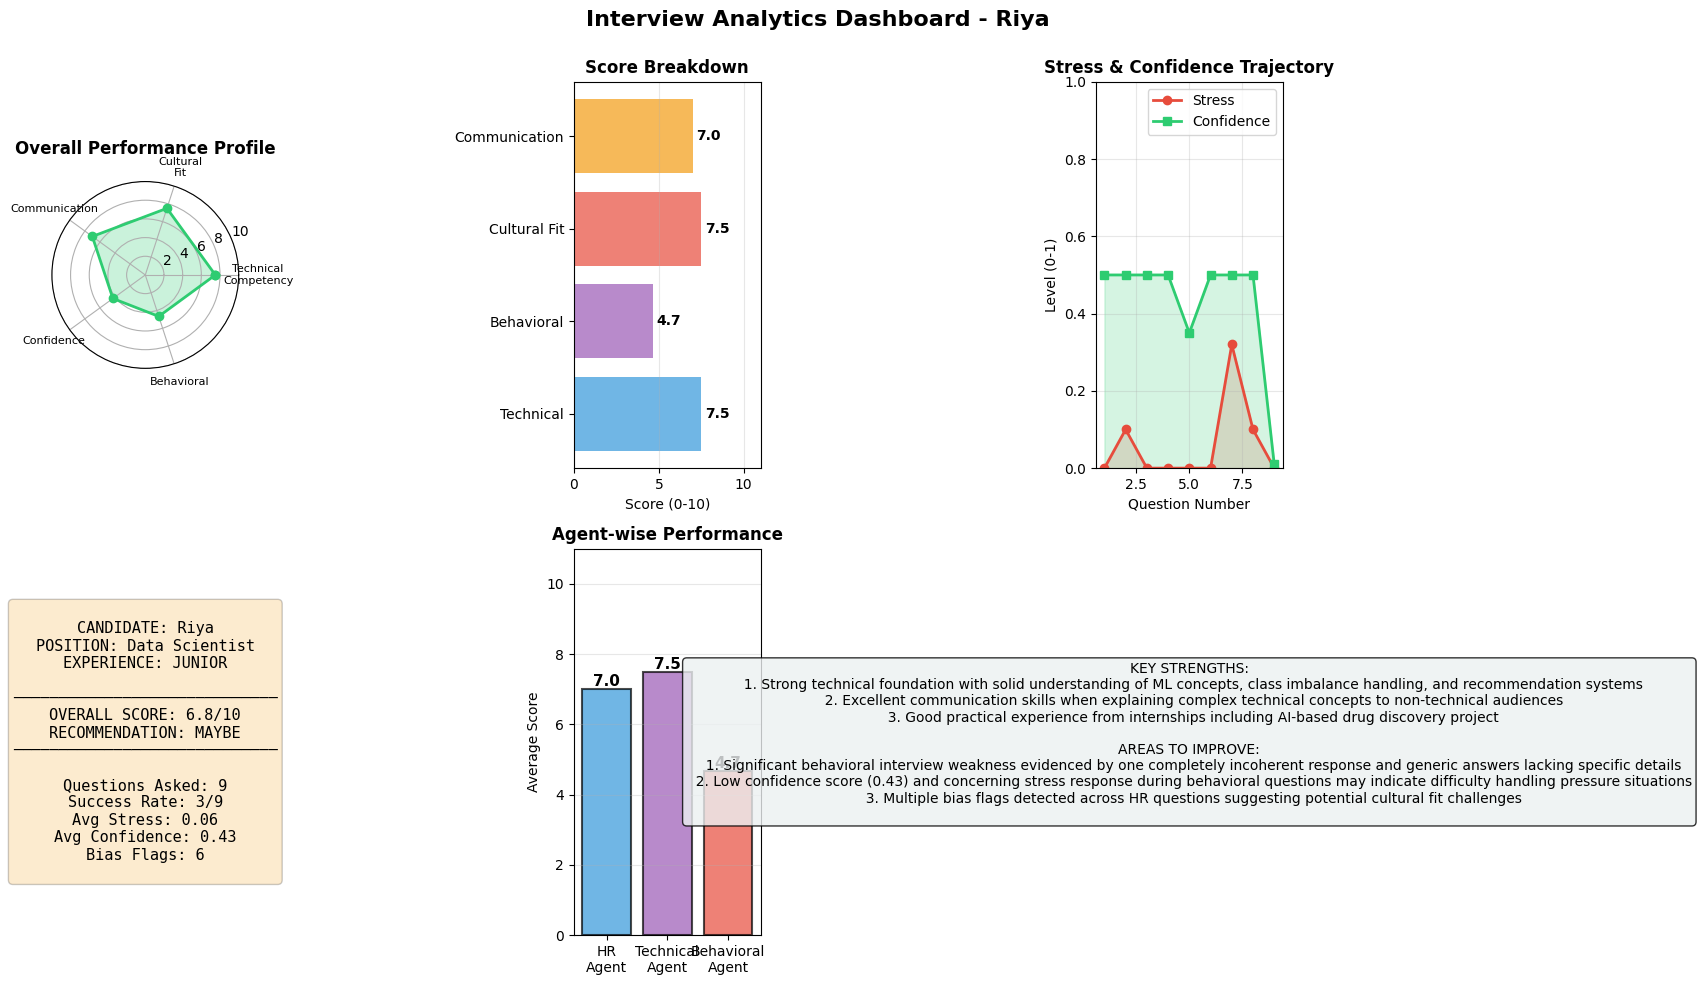


✅ Visualization complete!


In [80]:
visualize_interview_results(final_results)